# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from scipy.signal import correlate2d as conv2d
from torch._C import dtype
from IPython.display import clear_output
from time import sleep
from tqdm import tqdm

print(torch.__version__)

1.10.0+cu111


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

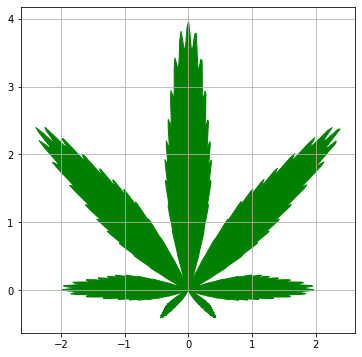

In [2]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
# rho = ### YOUR CODE
rho = (
    (1. + 0.9 * torch.cos(8 * theta)) * 
    (1. + 0.1 * torch.cos(24 * theta)) * 
    (0.9 + 0.05 * torch.cos(200 * theta)) * 
    (1. + torch.sin(theta))
)

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
# x = ### YOUR CODE
# y = ### YOUR CODE
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](https://www.samcodes.co.uk/project/game-of-life/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
numpy code inspired by: https://github.com/rougier/numpy-100


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [3]:
def np_update(Z: np.array):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = conv2d(Z, filters, mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [4]:
def torch_update(Z: torch.FloatTensor):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    #<Your code here!>
    Z_ = Z.clone()
    filters = torch.from_numpy(np.array([[1,1,1],
                                         [1,0,1],
                                         [1,1,1]])).type(torch.FloatTensor)

    N = torch.nn.functional.conv2d(input=Z_.reshape(1, 1, *Z_.size()), 
                                   weight=filters.reshape(1, 1, *filters.size()), 
                                   padding='same')
    
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    Z[:] = birth | survive

    return Z

In [5]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


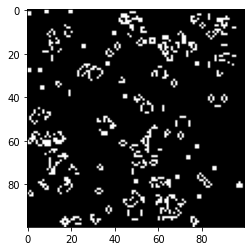

100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


In [6]:
# %matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in tqdm(range(100)):
    #update
    Z = torch_update(Z)
    
    #re-draw image
    # ax.clear()
    # ax.imshow(Z.numpy(), cmap='gray')
    # fig.canvas.draw()

    # alternative for Colab visualization
    clear_output(True)
    plt.imshow(Z.numpy(), cmap='gray')
    plt.show()
    sleep(0.05)

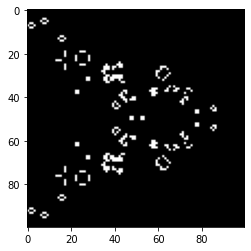

100%|██████████| 100/100 [00:22<00:00,  4.52it/s]


In [7]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in tqdm(range(100)):
    Z = torch_update(Z)
    # ax.clear()
    # ax.imshow(Z.numpy(),cmap='gray')
    # fig.canvas.draw()

    clear_output(True)
    plt.imshow(Z.numpy(), cmap='gray')
    plt.show()
    sleep(0.05)

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE) and/or [Jupyter Notebook](https://nbviewer.jupyter.org/url/norvig.com/ipython/Life.ipynb)

### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>

Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss) or [here](https://www.kaggle.com/dansbecker/what-is-log-loss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [8]:
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week02_autodiff/notmnist.py

In [9]:
%%time
from notmnist import load_notmnist

X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print(f'Train size: {X_train.shape}, test size: {X_test.shape}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done
Train size: (14043, 784), test size: (4681, 784)
CPU times: user 31.4 s, sys: 27.4 s, total: 58.8 s
Wall time: 30.3 s


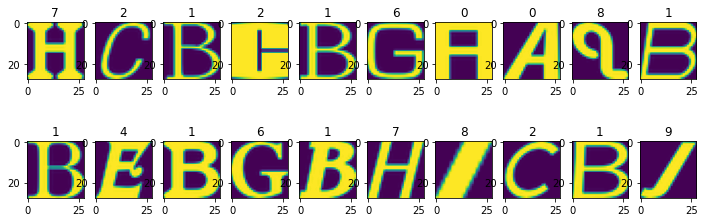

In [10]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

### Load data

In [11]:
#< a whole lot of your code > 
%%time
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(*map(lambda x: torch.from_numpy(x.copy()).to("cuda:0"), [X_train, y_train]))
test_ds = TensorDataset(*map(lambda x: torch.from_numpy(x.copy()).to("cuda:0"), [X_test, y_test]))

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, drop_last=True)
test_dl  = DataLoader(test_ds, batch_size=128, shuffle=False)

CPU times: user 1.6 s, sys: 704 ms, total: 2.31 s
Wall time: 2.3 s


### Define needed functions

In [18]:
def train(model, optimizer, loss_type, batchsize=32):
    loss_log, acc_log = [], []
        
    model.train()
    for x_batch, y_batch in tqdm(train_dl, leave=False):
        optimizer.zero_grad()
        output = model(x_batch)

        if loss_type == 'cross_entropy':
            loss = F.cross_entropy(output, y_batch)
        elif loss_type == 'nll_loss':
            loss = F.nll_loss(output, y_batch)
        else:
            raise Exception('Unsupported type of loss!')

        loss.backward()
        optimizer.step()

        pred = torch.max(output, 1).indices
        acc = (pred == y_batch).sum() / y_batch.shape[0]
        acc_log.append(acc.item())

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

@torch.inference_mode()
def test(model, loss_type):
    loss_log, acc_log = [], []
    model.eval()

    for x_batch, y_batch in tqdm(test_dl, leave=False):
        output = model(x_batch)

        if loss_type == 'cross_entropy':
            loss = F.cross_entropy(output, y_batch)
        elif loss_type == 'nll_loss':
            loss = F.nll_loss(output, y_batch)
        else:
            raise Exception('Unsupported type of loss!')

        loss = loss.item()
        loss_log.append(loss)
        
        pred = torch.max(output, 1).indices
        acc = (pred == y_batch).sum() / y_batch.shape[0]
        acc_log.append(acc.item())

    return loss_log, acc_log

def plot_history(train_history, val_history, epoch, title='loss'):
    plt.figure()

    plt.title('{} at {} epoch'.format(title, epoch+1))
    plt.plot(train_history, label='train', zorder=1)
    
    points = torch.tensor(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train_eval_model(clf, loss_type, n_epoch=20, lr=0.0005, momentum=0.95):
    train_log, train_acc_log = [],[]
    val_log, val_acc_log = [],[]

    model = clf.to("cuda:0")
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    steps = len(train_ds) / 128

    for epoch in range(n_epoch):
        train_loss, train_acc = train(model, opt, loss_type)
        val_loss, val_acc = test(model, loss_type)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_history(train_log, val_log, epoch)    
        plot_history(train_acc_log, val_acc_log, epoch, title='accuracy')    
    return val_acc_log[-1][1]

### Define Neural Network and Logistict Regression models

In [19]:
class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        return x

class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(X_train.shape[1], 10)
        
    def forward(self, x):
        x = F.sigmoid(self.fc(x))
        return x

### Compare two models performance

In [20]:
net = Net()
logreg = LogReg()

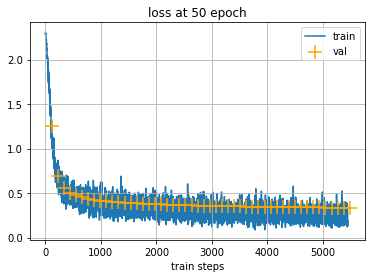

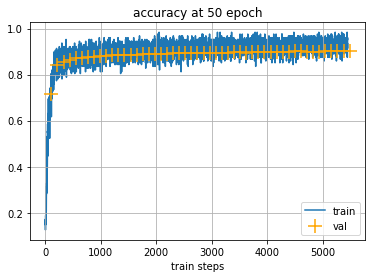

Test accuracy on last epoch: 90.3%
CPU times: user 40.9 s, sys: 1.42 s, total: 42.3 s
Wall time: 43 s


In [21]:
%%time
print('Neural Network')
last_epoch_test_accuracy = train_eval_model(net, loss_type='nll_loss', n_epoch=50, lr=0.0005, momentum=0.95)
print(f'Test accuracy on last epoch: {100*last_epoch_test_accuracy:.1f}%')

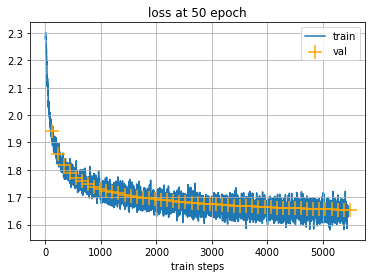

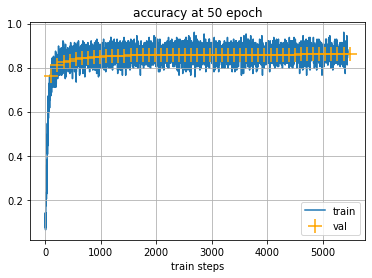

Test accuracy on last epoch: 86.1%


In [22]:
print('Logistict Regression')
last_epoch_test_accuracy = train_eval_model(logreg, loss_type='cross_entropy', n_epoch=50, lr=0.0005, momentum=0.95)
print(f'Test accuracy on last epoch: {100*last_epoch_test_accuracy:.1f}%')

### Conclusions

Using the same learning parameters:
* NN gives a __90.3%__ accuracy (Input -> FC -> ReLu -> FC -> LogSoftmax) with NLLLoss
* LogReg gives a __86.1%__ accuracy (Input -> FC -> Sigmoid) with CrossEntropyLoss

# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal case this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

